In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score, roc_curve)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
def plot_distribution(data, columns, target_col='target', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Histograma por clase
            for target_val in data[target_col].unique():
                subset = data[data[target_col] == target_val]
                axes[i].hist(subset[col], alpha=0.7, label=f'Clase {target_val}', bins=20)
            
            axes[i].set_title(f'Distribución de {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
            axes[i].legend()
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(data, figsize=(8, 4)):
    
    corr_matrix = data.corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Generar heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdYlBu_r',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Matriz de Correlación de Variables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def plot_outliers(data, columns, target_col='target', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            sns.boxplot(data=data, x=target_col, y=col, ax=axes[i])
            axes[i].set_title(f'Boxplot de {col}')
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_class_balance(y, title="Distribución de Clases"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Gráfico de barras
    value_counts = y.value_counts()
    ax1.bar(value_counts.index, value_counts.values, color='skyblue')
    ax1.set_title(f'{title} - Conteo')
    ax1.set_xlabel('Clase')
    ax1.set_ylabel('Cantidad')
    
    # Gráfico de pastel
    ax2.pie(value_counts.values, labels=[f'Clase {i}' for i in value_counts.index], 
            autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    ax2.set_title(f'{title} - Porcentaje')
    
    plt.tight_layout()
    plt.show()

## evaluacion
def evaluate_model(model, X_test, y_test, y_pred, model_name):
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred)
    }
    
    return results

def plot_confusion_matrices(models_results, y_test, figsize=(15, 12)):

    n_models = len(models_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, (model_name, results) in enumerate(models_results.items()):
        if i < len(axes):
            y_pred = results['predictions']
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Matriz de Confusión - {model_name}')
            axes[i].set_xlabel('Predicción')
            axes[i].set_ylabel('Real')
    
    # Ocultar ejes vacíos
    for i in range(len(models_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(models_results, y_test, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    for model_name, results in models_results.items():
        y_pred_proba = results.get('probabilities')
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC - Comparación de Modelos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [5]:
# Cargar datos
data = pd.read_csv("wine_quality_synthetic.csv")

In [6]:

# 3. CARGA Y EXPLORACIÓN INICIAL DE DATOS
print(f"\n📊 INFORMACIÓN GENERAL DEL DATASET:")
print(f"   • Forma del dataset: {data.shape}")
print(f"   • Número de variables: {data.shape[1] - 1}")
print(f"   • Número de observaciones: {data.shape[0]}")

print(f"\n🔍 TIPOS DE DATOS:")
print(data.dtypes.value_counts())

print(f"\n❌ DATOS FALTANTES:")
missing_data = data.isnull().sum()
print(f"   • Total de valores faltantes: {missing_data.sum()}")
if missing_data.sum() > 0:
    print(missing_data[missing_data > 0])
else:
    print("   • No hay valores faltantes en el dataset ✅")

print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
print(data.describe())



📊 INFORMACIÓN GENERAL DEL DATASET:
   • Forma del dataset: (1500, 12)
   • Número de variables: 11
   • Número de observaciones: 1500

🔍 TIPOS DE DATOS:
float64    11
int64       1
Name: count, dtype: int64

❌ DATOS FALTANTES:
   • Total de valores faltantes: 0
   • No hay valores faltantes en el dataset ✅

📊 ESTADÍSTICAS DESCRIPTIVAS:
       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    1500.000000       1500.000000  1500.000000     1500.000000   
mean        8.405346          0.532691     0.269884        4.477676   
std         1.722988          0.177015     0.177988        4.362117   
min         2.680195         -0.013512     0.000000        0.500000   
25%         7.234185          0.415626     0.130223        1.927427   
50%         8.407701          0.529633     0.265996        3.254730   
75%         9.503328          0.650725     0.386353        5.561539   
max        15.023753          1.236723     0.886188       40.057990   

         chlorides  f


🎯 ANÁLISIS DE LA VARIABLE OBJETIVO:
   • Clase 0 (Mal vino): 900 (60.0%)
   • Clase 1 (Buen vino): 600 (40.0%)


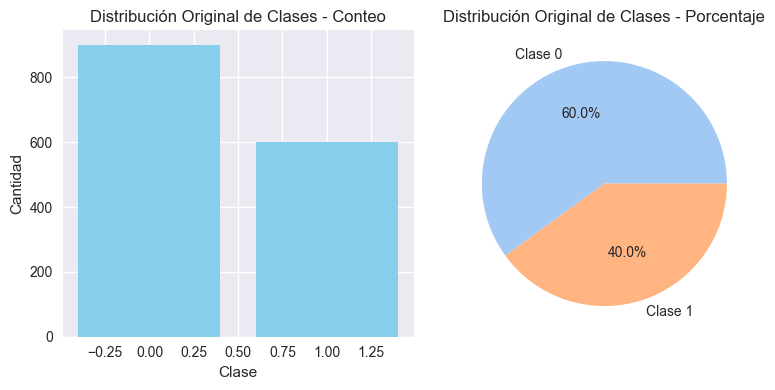

In [7]:

# 4. ANÁLISIS DE LA VARIABLE OBJETIVO

print(f"\n🎯 ANÁLISIS DE LA VARIABLE OBJETIVO:")
target_distribution = data['target'].value_counts()
print(f"   • Clase 0 (Mal vino): {target_distribution[0]} ({target_distribution[0]/len(data)*100:.1f}%)")
print(f"   • Clase 1 (Buen vino): {target_distribution[1]} ({target_distribution[1]/len(data)*100:.1f}%)")

plot_class_balance(data['target'], "Distribución Original de Clases")


📈 ANÁLISIS DE DISTRIBUCIONES:


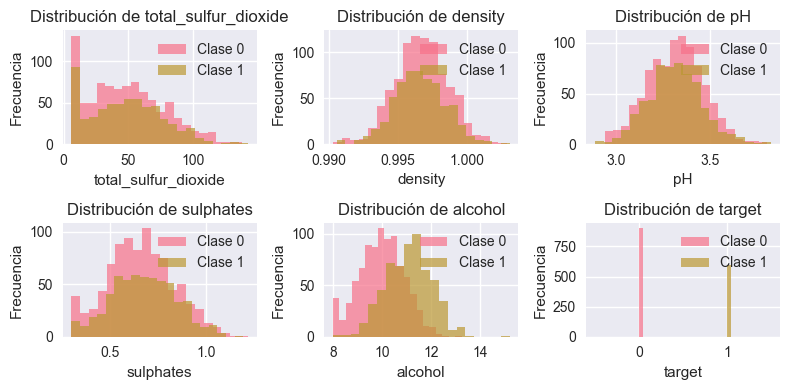

In [11]:
# 5. ANÁLISIS DE DISTRIBUCIONES

print(f"\n📈 ANÁLISIS DE DISTRIBUCIONES:")

# Seleccionar columnas principales para análisis
main_features =['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'target']

# Generar gráficos de distribución
plot_distribution(data, main_features[-6:])

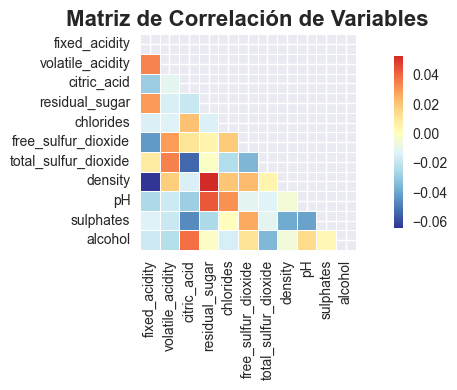


🎯 CORRELACIONES MÁS ALTAS CON LA VARIABLE OBJETIVO:
    1. alcohol                  : 0.508
    2. fixed_acidity            : 0.171
    3. volatile_acidity         : 0.078
    4. citric_acid              : 0.068
    5. free_sulfur_dioxide      : 0.059
    6. sulphates                : 0.047
    7. density                  : 0.034
    8. pH                       : 0.009
    9. total_sulfur_dioxide     : 0.006
   10. chlorides                : 0.005


In [12]:
# 6. ANÁLISIS DE CORRELACIONES
# Matriz de correlación
corr_matrix = plot_correlation_matrix(data.drop('target', axis=1))

# Correlaciones más altas con la variable objetivo
target_correlations = data.corr()['target'].abs().sort_values(ascending=False)
print(f"\n🎯 CORRELACIONES MÁS ALTAS CON LA VARIABLE OBJETIVO:")
for i, (feature, corr) in enumerate(target_correlations[1:11].items()):
    print(f"   {i+1:2d}. {feature:<25}: {corr:.3f}")



⚠️  ANÁLISIS DE OUTLIERS:


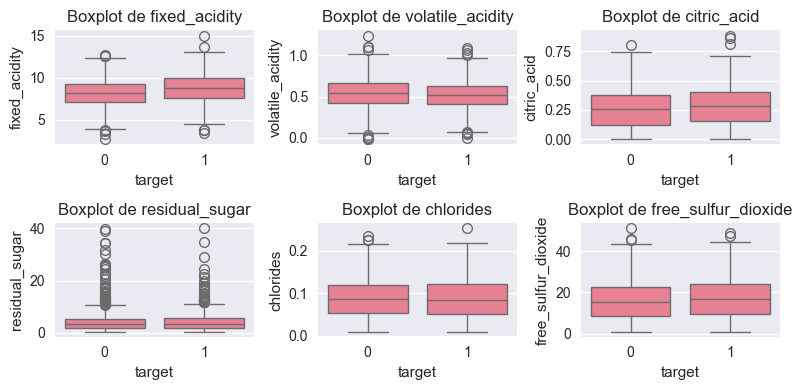


📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):
   • fixed_acidity            :  10 outliers
   • volatile_acidity         :  18 outliers
   • citric_acid              :   4 outliers
   • residual_sugar           :  92 outliers
   • chlorides                :   4 outliers
   • free_sulfur_dioxide      :   5 outliers
   • total_sulfur_dioxide     :   3 outliers
   • density                  :  20 outliers
   • pH                       :  11 outliers
   • sulphates                :   3 outliers
   • alcohol                  :   2 outliers
   • target                   :   0 outliers


In [13]:

# 7. DETECCIÓN DE OUTLIERS
# ========================

print(f"\n⚠️  ANÁLISIS DE OUTLIERS:")

# Generar boxplots para las características principales
plot_outliers(data, main_features[:6])

# Detectar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_count = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count[col] = len(outliers)
    return outliers_count

outliers_info = detect_outliers_iqr(data, main_features)
print(f"\n📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):")
for feature, count in outliers_info.items():
    print(f"   • {feature:<25}: {count:3d} outliers")



In [14]:
# 8. PREPARACIÓN DE DATOS
# =======================
print(f"\n🔧 PREPARACIÓN DE DATOS:")

# Separar características y variable objetivo
X = data.drop('target', axis=1)
y = data['target']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"   • Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"   • Tamaño conjunto prueba: {X_test.shape}")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   • Características escaladas ✅")




🔧 PREPARACIÓN DE DATOS:
   • Tamaño conjunto entrenamiento: (1200, 11)
   • Tamaño conjunto prueba: (300, 11)
   • Características escaladas ✅



⚖️  BALANCEADO DE DATOS:
   • Ratio de balance: 0.674
   • Aplicando SMOTE + Tomek Links...
   • Datos balanceados:
     - Antes: {0: 717, 1: 483}
     - Después: {0: 690, 1: 690}


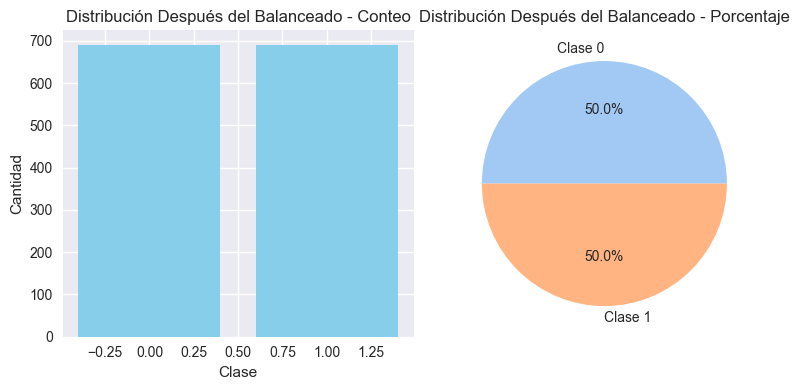

In [16]:
# 9. BALANCEADO DE DATOS (OPCIONAL)
# =================================

print(f"\n⚖️  BALANCEADO DE DATOS:")

# Verificar si es necesario balancear
class_counts = y_train.value_counts()
balance_ratio = min(class_counts) / max(class_counts)
print(f"   • Ratio de balance: {balance_ratio:.3f}")

if balance_ratio < 0.8:  # Si el desbalance es significativo
    print(f"   • Aplicando SMOTE + Tomek Links...")
    
    # Aplicar SMOTE + Tomek Links
    smote_tomek = SMOTETomek(random_state=42)
    X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)
    
    print(f"   • Datos balanceados:")
    print(f"     - Antes: {y_train.value_counts().to_dict()}")
    print(f"     - Después: {pd.Series(y_train_balanced).value_counts().to_dict()}")
    
    # Visualizar el balanceado
    plot_class_balance(pd.Series(y_train_balanced), "Distribución Después del Balanceado")
    
    # Usar datos balanceados
    X_train_final = X_train_balanced
    y_train_final = y_train_balanced
else:
    print(f"   • No es necesario balancear los datos")
    X_train_final = X_train_scaled
    y_train_final = y_train



In [23]:
# 10. ENTRENAMIENTO DE MODELOS
# ============================
print(f"\n🤖 ENTRENAMIENTO DE MODELOS:")

models_results = {}

# 4. Logistic Regression
print("🔹 Entrenando Logistic Regression...")
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train_final)
lr_pred = lr_model.predict(X_test_scaled)
models_results['Logistic Regression'] = {
    'model': lr_model,
    'predictions': lr_pred
}


# 1. Support Vector Machine
print("🔹 Entrenando SVM...")
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_final, y_train_final)
svm_pred = svm_model.predict(X_test_scaled)
models_results['SVM'] = {
    'model': svm_model,
    'predictions': svm_pred
}

# 2. Decision Tree
print("🔹 Entrenando Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=2, random_state=42)
dt_model.fit(X_train_final, y_train_final)
dt_pred = dt_model.predict(X_test_scaled)
models_results['Decision Tree3'] = {
    'model': dt_model,
    'predictions': dt_pred
}


# 2. Decision Tree
print("🔹 Entrenando Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=9, random_state=42)
dt_model.fit(X_train_final, y_train_final)
dt_pred = dt_model.predict(X_test_scaled)
models_results['Decision Tree9'] = {
    'model': dt_model,
    'predictions': dt_pred
}

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_final)
rf_pred = rf_model.predict(X_test_scaled)
models_results['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_pred
}


🤖 ENTRENAMIENTO DE MODELOS:
🔹 Entrenando Logistic Regression...
🔹 Entrenando SVM...
🔹 Entrenando Decision Tree...
🔹 Entrenando Decision Tree...


In [24]:
# 11. EVALUACIÓN DE MODELOS
# =========================

print(f"\n📊 EVALUACIÓN DE MODELOS:")

# Calcular métricas para todos los modelos
evaluation_results = []

for model_name, results in models_results.items():
    metrics = evaluate_model(
        results['model'], 
        X_test_scaled, 
        y_test, 
        results['predictions'], 
        model_name
    )
    evaluation_results.append(metrics)
    
    print(f"\n🔸 {model_name}:")
    print(f"   • Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"   • Precision: {metrics['Precision']:.4f}")
    print(f"   • Recall:    {metrics['Recall']:.4f}")
    print(f"   • F1-Score:  {metrics['F1-Score']:.4f}")
    
# Crear DataFrame con resultados
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Model')
results_df = results_df.round(4)

print(f"\n📋 TABLA COMPARATIVA DE RESULTADOS:")
print("=" * 60)
print(results_df)

# Identificar el mejor modelo por métrica
print(f"\n🏆 MEJORES MODELOS POR MÉTRICA:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"   • {metric:<10}: {best_model} ({best_score:.4f})")




📊 EVALUACIÓN DE MODELOS:

🔸 Logistic Regression:
   • Accuracy:  0.7467
   • Precision: 0.6475
   • Recall:    0.7692
   • F1-Score:  0.7031

🔸 SVM:
   • Accuracy:  0.7367
   • Precision: 0.6484
   • Recall:    0.7094
   • F1-Score:  0.6776

🔸 Decision Tree3:
   • Accuracy:  0.7733
   • Precision: 0.7333
   • Recall:    0.6581
   • F1-Score:  0.6937

🔸 Decision Tree9:
   • Accuracy:  0.7000
   • Precision: 0.6047
   • Recall:    0.6667
   • F1-Score:  0.6341

🔸 Random Forest:
   • Accuracy:  0.7567
   • Precision: 0.6774
   • Recall:    0.7179
   • F1-Score:  0.6971

📋 TABLA COMPARATIVA DE RESULTADOS:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
Logistic Regression    0.7467     0.6475  0.7692    0.7031   0.7507
SVM                    0.7367     0.6484  0.7094    0.6776   0.7318
Decision Tree3         0.7733     0.7333  0.6581    0.6937   0.7526
Decision Tree9         0.7000     0.6047  0.6667  


📈 GENERANDO VISUALIZACIONES:


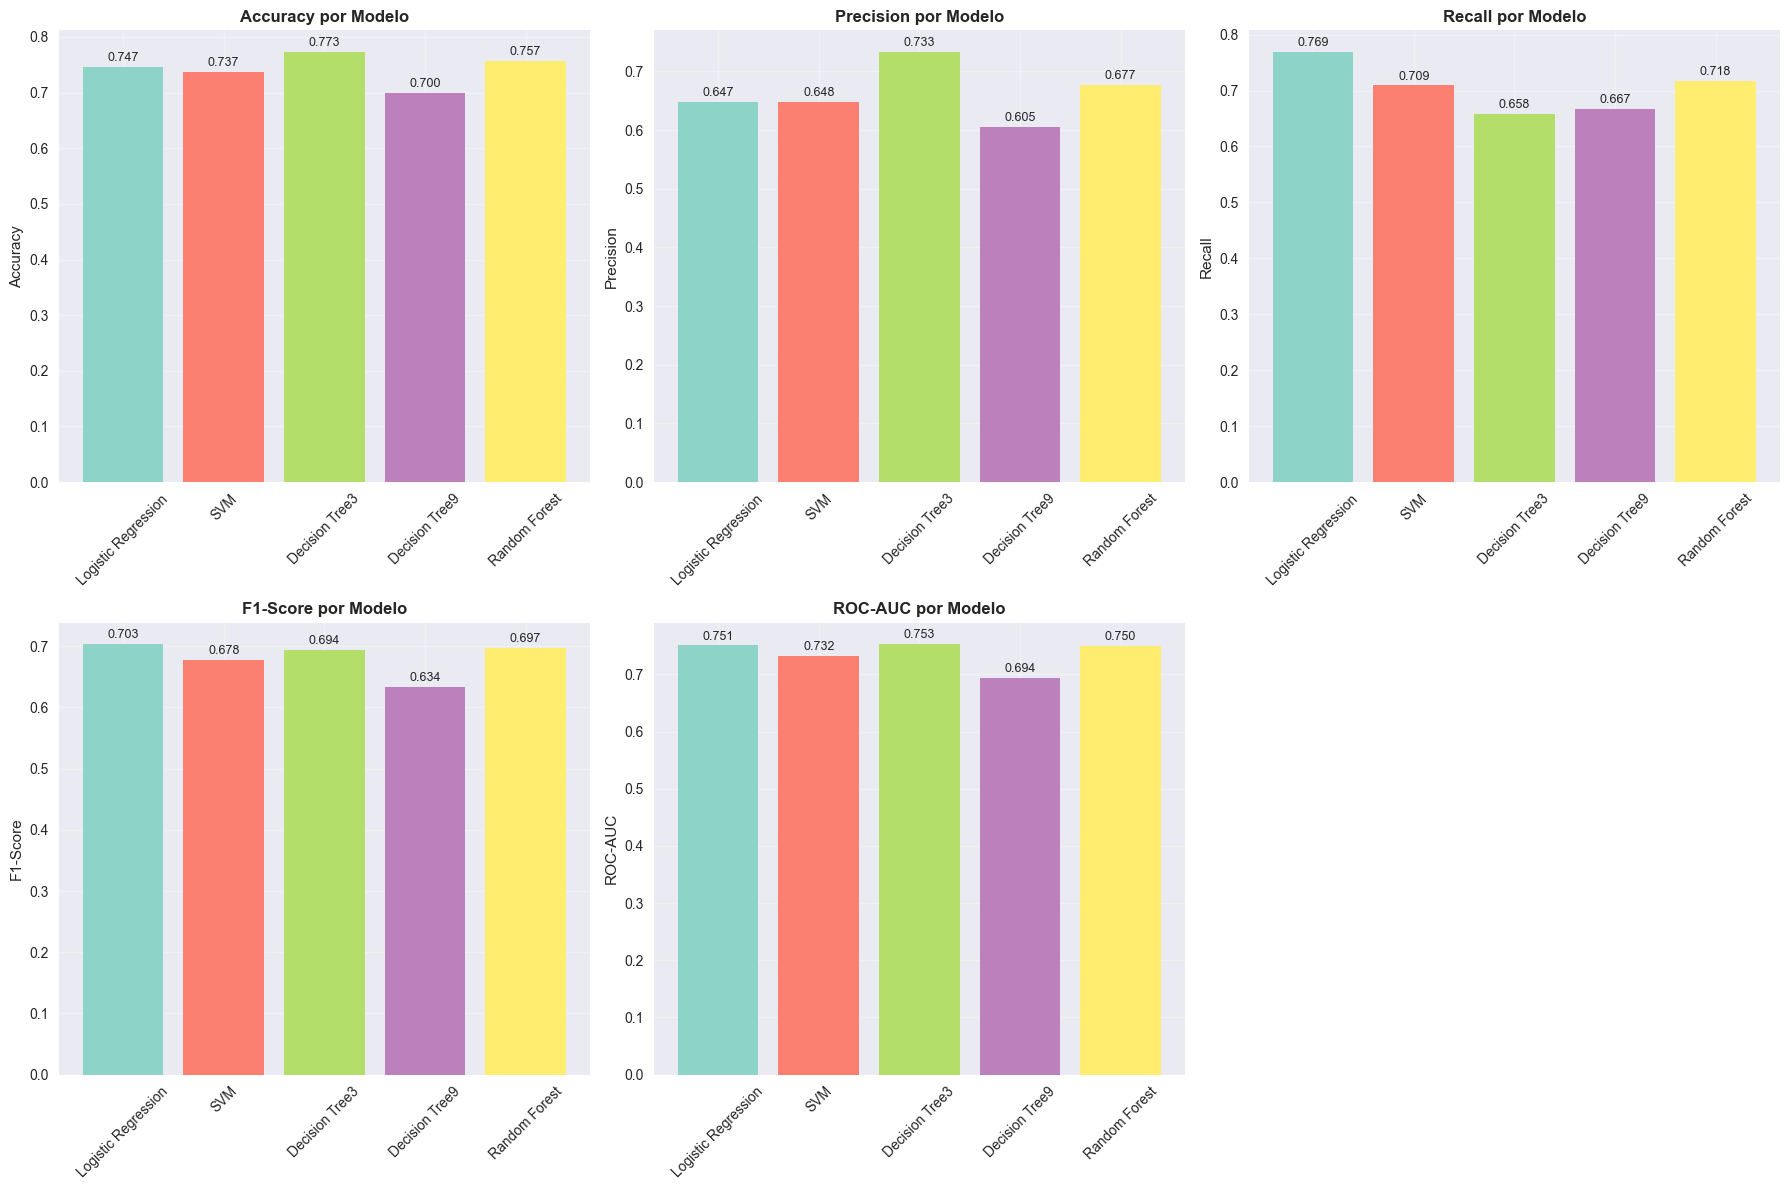

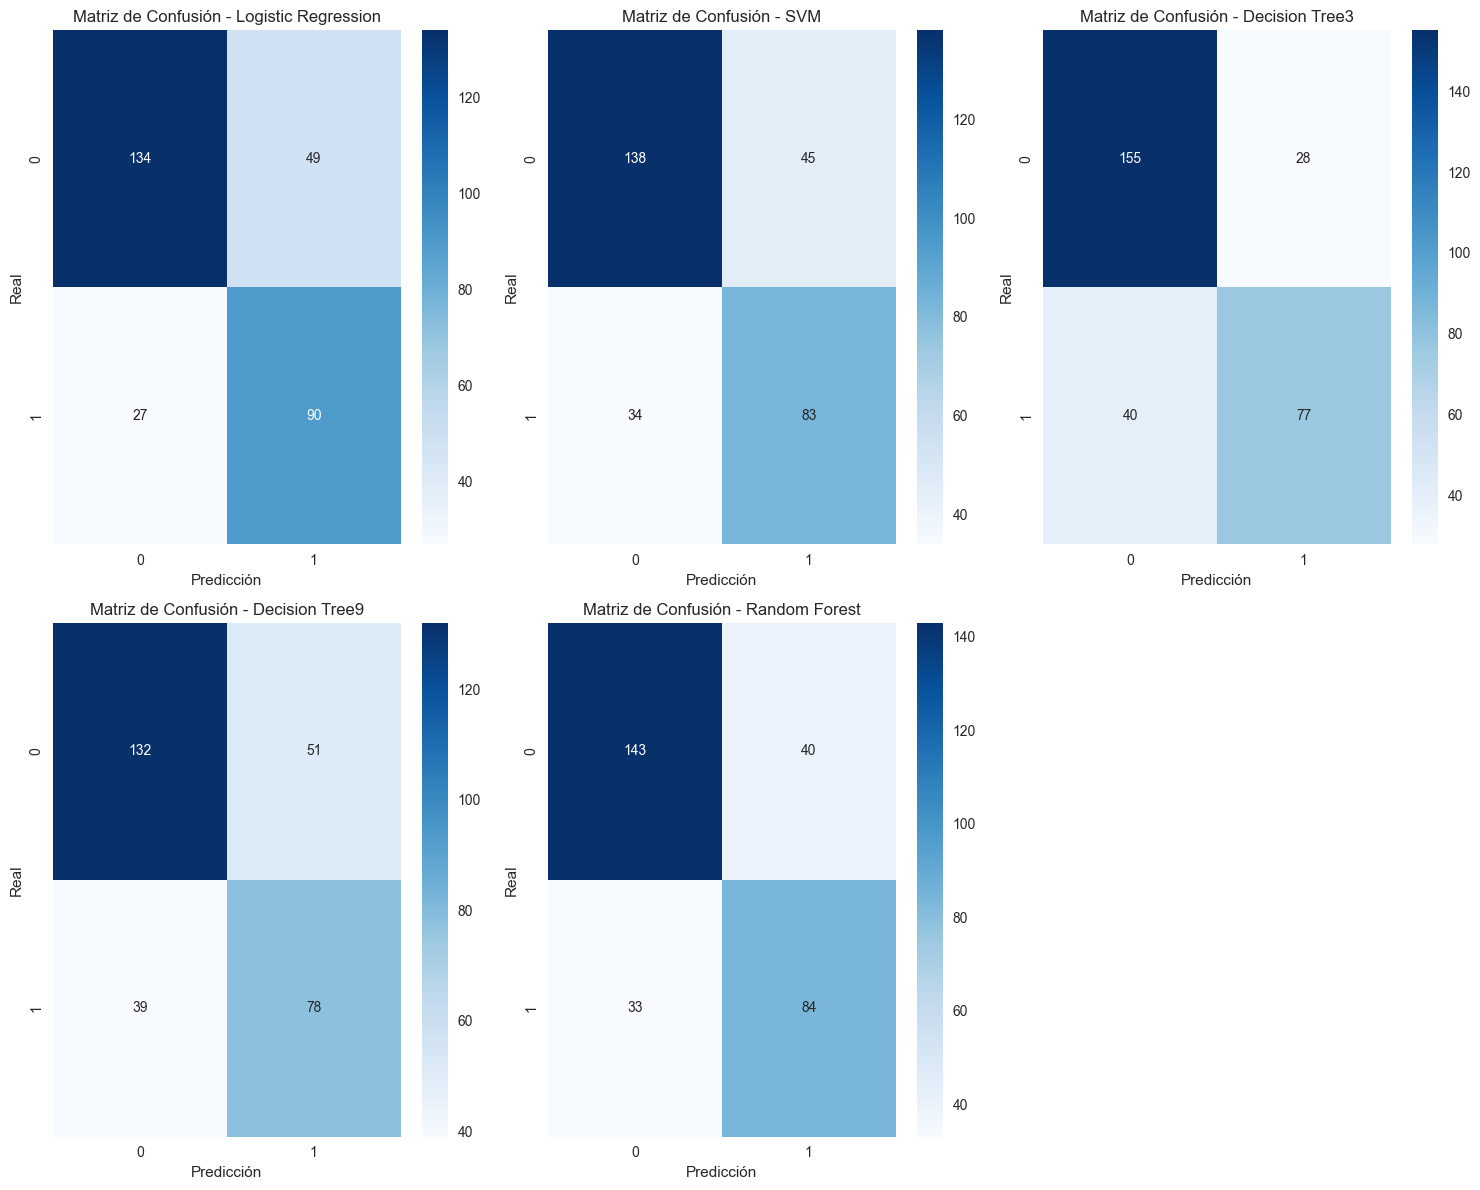

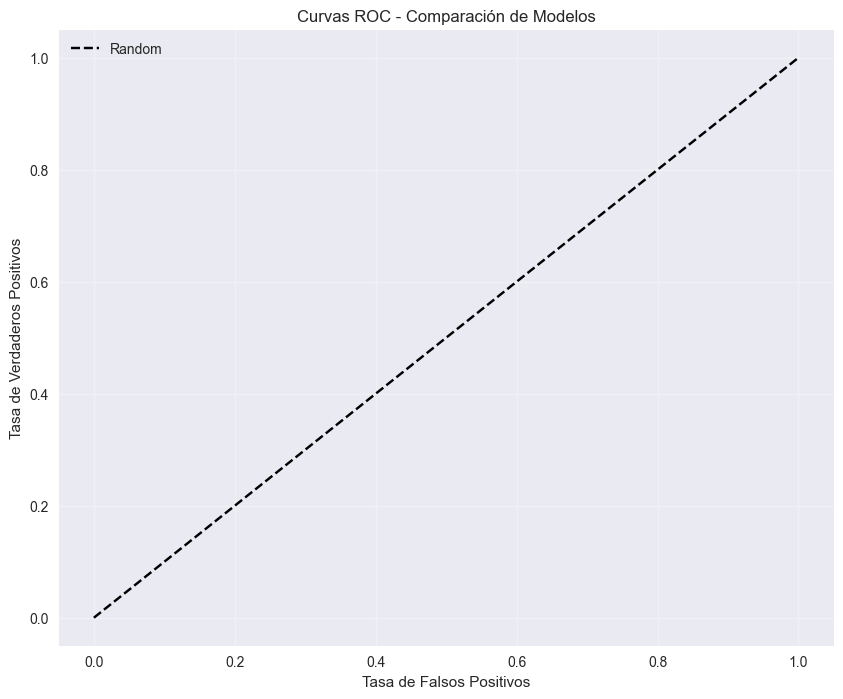

In [25]:
# 12. VISUALIZACIÓN DE RESULTADOS
# ===============================

print(f"\n📈 GENERANDO VISUALIZACIONES:")

# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))

for i, metric in enumerate(metrics):
    if i < len(axes):
        bars = axes[i].bar(results_df.index, results_df[metric], color=colors)
        axes[i].set_title(f'{metric} por Modelo', fontweight='bold')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)
        
        # Agregar valores en las barras
        for bar, value in zip(bars, results_df[metric]):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Ocultar el último subplot si es necesario
if len(metrics) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Matrices de confusión
plot_confusion_matrices(models_results, y_test)

# Curvas ROC
plot_roc_curves(models_results, y_test)




🔍 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS:

🌳 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (SVM):
    1. alcohol                  : 0.3090
    2. fixed_acidity            : 0.0936
    3. volatile_acidity         : 0.0741
    4. density                  : 0.0736
    5. residual_sugar           : 0.0672
    6. sulphates                : 0.0671
    7. total_sulfur_dioxide     : 0.0668
    8. free_sulfur_dioxide      : 0.0651
    9. pH                       : 0.0634
   10. chlorides                : 0.0610


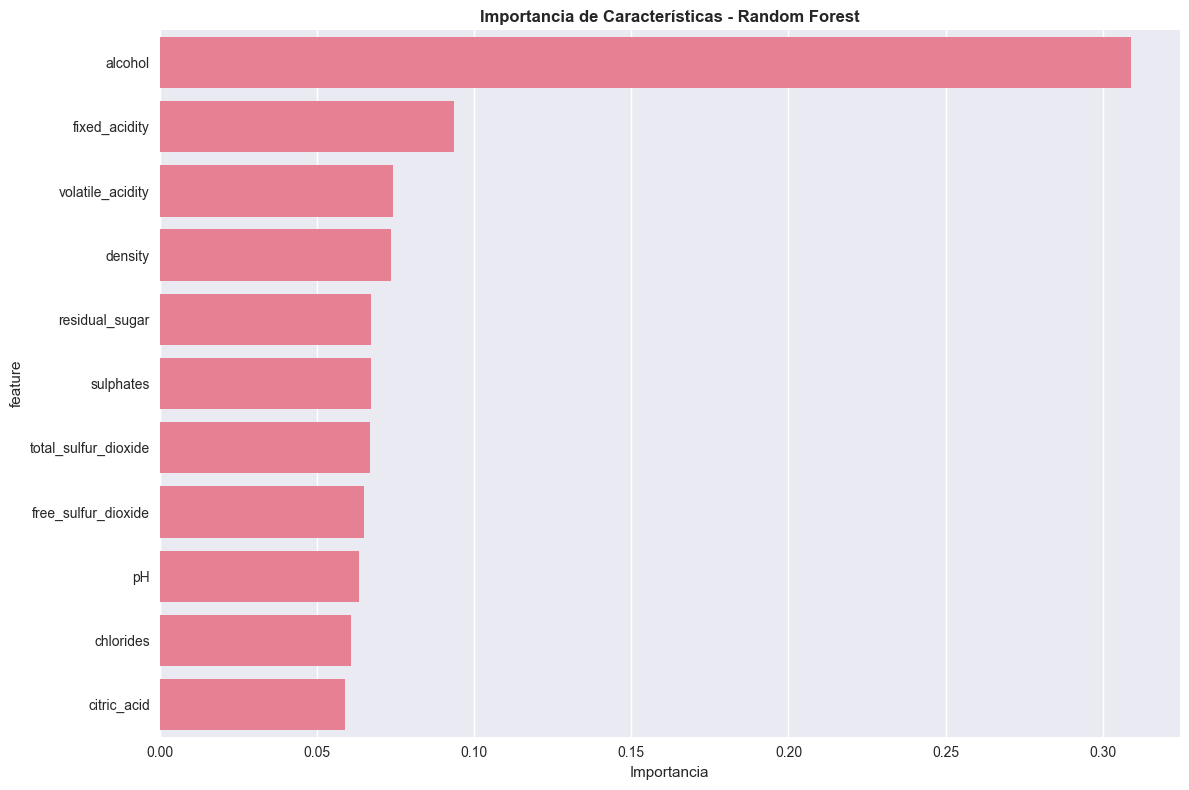

In [29]:
# 13. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
# =============================================

print(f"\n🔍 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS:")

# Para Random Forest
if 'Random Forest' in models_results:
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': models_results['Random Forest']['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🌳 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (SVM):")
    for i, (_, row) in enumerate(rf_importance.head(10).iterrows()):
        print(f"   {i+1:2d}. {row['feature']:<25}: {row['importance']:.4f}")
    
    # Visualización
    plt.figure(figsize=(12, 8))
    sns.barplot(data=rf_importance.head(15), x='importance', y='feature')
    plt.title('Importancia de Características - Random Forest', fontweight='bold')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()


In [27]:

# 14. VALIDACIÓN CRUZADA
# ======================

print(f"\n✅ VALIDACIÓN CRUZADA (5-fold):")

cv_results = {}
for model_name, results in models_results.items():
    cv_scores = cross_val_score(results['model'], X_train_final, y_train_final, cv=5)
    cv_results[model_name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"   • {model_name:<20}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")



✅ VALIDACIÓN CRUZADA (5-fold):
   • Logistic Regression : 0.7406 (±0.0237)
   • SVM                 : 0.7391 (±0.0263)
   • Decision Tree3      : 0.7130 (±0.0224)
   • Decision Tree9      : 0.6790 (±0.0312)
   • Random Forest       : 0.7819 (±0.0230)


In [ ]:

# 15. PREGUNTAS DE ANÁLISIS Y RESPUESTAS
# ======================================

# 1. ¿Cuál es el mejor modelo overall?
# 2. ¿Hay diferencias significativas entre modelos?
# 3. ¿Qué modelo es mejor para minimizar falsos negativos?
# 4. ¿Qué modelo es mejor para minimizar falsos positivos?
# 5. ¿Los datos estaban bien balanceados?

# 6. ¿Qué características son más importantes?

# 7. ¿La validación cruzada confirma los resultados?
# 8. ¿Hay overfitting en algún modelo?
# 9. ¿Qué modelo recomendamos para producción?
# 10. ¿Cuál es la confianza en las predicciones?

In [1]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

iris = datasets.load_breast_cancer()

In [2]:
X = iris.data
Y = iris.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [3]:
## modelo tradicional
svc = svm.SVC()
svc.fit(X_train, Y_train)
acc = accuracy_score(svc.predict(X_test), Y_test)
f1 = f1_score(svc.predict(X_test), Y_test)
print(f"acc:{acc}\tf1:{f1}")

acc:0.951048951048951	f1:0.9617486338797814


In [ ]:
## modelo buscando parámetros
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, scoring='f1_macro')
clf.fit(X_train, Y_train)
sorted(clf.cv_results_.keys())

In [6]:
clf.best_estimator_

SVC(C=10, kernel='linear')

In [ ]:
svm_parameters = {
    "regresion":{
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf'],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.01, 0.2, 0.5]    
    },
    "clasificacion":{
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf'],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4] #solo para kernel polinómico
    }
}

decision_tree_parameters = {
    "regresion":{
        "criterion": ['squared_error', 'friedman_mse', 'absolute_error'],
        'max_depth': [None, 3, 5, 7, 15, 20],
        'max_leaf_nodes': [None, 10, 20, 30]
    },
    "clasificacion":{
        "criterion": ['gini', 'entropy'],
        'max_depth': [None, 3, 5, 7, 15, 20],
        'max_leaf_nodes': [None, 10, 20, 30]
    }
}

random_forest_parameters = {
    "clasificacion":{
        'n_estimators': [10, 50, 100, 500, 1000],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 3, 5, 7, 15, 20],
        'max_leaf_nodes': [None, 10, 20, 30],
        'bootstrap': [True, False]
    },
    "regresion":{
        'n_estimators': [10, 50, 100, 500, 1000],
        "criterion": ['squared_error', 'absolute_error'],
        'max_depth': [None, 3, 5, 7, 15, 20],
        'max_leaf_nodes': [None, 10, 20, 30],
        'bootstrap': [True, False]
    }
    
}

xg_boost_parameters = {
    "clasificacion":{
        'n_estimators': [10, 50, 100, 500, 1000],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 3, 5, 7, 15, 20],
        'gamma': [0, 0.1, 0.5]
    },
    "regresion":{
        'n_estimators': [10, 50, 100, 500, 1000],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 3, 5, 7, 15, 20],
        'gamma': [0, 0.1, 0.5]
    }
}

In [11]:
parameters = {
    "svm": svm_parameters,
    "dt": decision_tree_parameters,
    "rf": random_forest_parameters,
    "xgb": xg_boost_parameters
}

In [12]:
parameters

{'svm': {'regresion': {'C': [0.1, 1, 10, 100],
   'kernel': ['linear', 'poly', 'rbf'],
   'gamma': ['scale', 'auto'],
   'epsilon': [0.01, 0.2, 0.5]},
  'clasificacion': {'C': [0.1, 1, 10, 100],
   'kernel': ['linear', 'poly', 'rbf'],
   'gamma': ['scale', 'auto'],
   'degree': [2, 3, 4]}},
 'dt': {'regresion': {'criterion': ['squared_error',
    'friedman_mse',
    'absolute_error'],
   'max_depth': [None, 3, 5, 7, 15, 20],
   'max_leaf_nodes': [None, 10, 20, 30]},
  'clasificacion': {'criterion': ['gini', 'entropy'],
   'max_depth': [None, 3, 5, 7, 15, 20],
   'max_leaf_nodes': [None, 10, 20, 30]}},
 'rf': {'clasificacion': {'n_estimators': [10, 50, 100, 500, 1000],
   'criterion': ['gini', 'entropy'],
   'max_depth': [None, 3, 5, 7, 15, 20],
   'max_leaf_nodes': [None, 10, 20, 30],
   'bootstrap': [True, False]},
  'regresion': {'n_estimators': [10, 50, 100, 500, 1000],
   'criterion': ['squared_error', 'absolute_error'],
   'max_depth': [None, 3, 5, 7, 15, 20],
   'max_leaf_nodes':

In [ ]:
parameters['svm']['clasificacion']

In [1]:
parameters['svm']['clasificacion']

NameError: name 'parameters' is not defined

In [ ]:
svc = svm.SVC()
clf = GridSearchCV(svc, parameters['svm']['clasificacion'])
clf.fit(X_train, Y_train)
sorted(clf.cv_results_.keys())